---

# <center>★Computer Vision Project - Document Scanner★

---

<center> <img src="https://raw.githubusercontent.com/Masterx-AI/Project_OCR_Document_Scanner/main/z1.png" style="width: 600px;"/> <center/>

---

### Description:

OpenCV is a library written in C++ aimed to provide an infrastructure for computer vision and machine learning. The library contains more than 2500 algorithms that are used for facial detection, gesture recognition, augmented reality, track moving objects, identify objects, etc.

In this tutorial we will create a simple document scanner using the OpenCV library. This can be useful, for example, for scanning pages in a book.

This is a beginner tutorial so I will explain in details each line of code so that you can follow along with me.

The steps that we need to follow to build this project are:

Convert the image to grayscale
Find the edges in the image
Use the edges to find all the contours
Select only the contours of the document
Apply warp perspective to get the top-down view of the document


### Acknowledgement: 
OpenCV Library developed by Intel

### Objective:
- Object Character Recognition using OpenCV

---

# <center> 1. Data Exploration

In [182]:
# Importing the basic libraries

import cv2
import glob
import numpy as np
import pytesseract
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,8]


import warnings 
warnings.filterwarnings('ignore')

In [183]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\atif7\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'


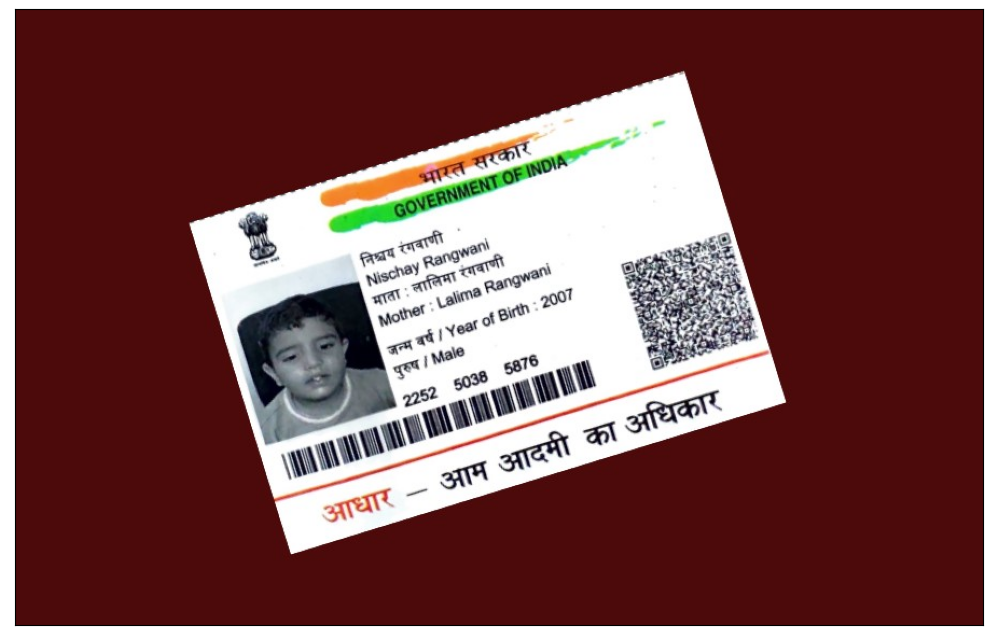

In [184]:
# Reading the image file
img = cv2.imread('datasets\\aadhar.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plotting the image
def plot_image(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(img)
plt.show()

---

# <center> 2. Image Processing

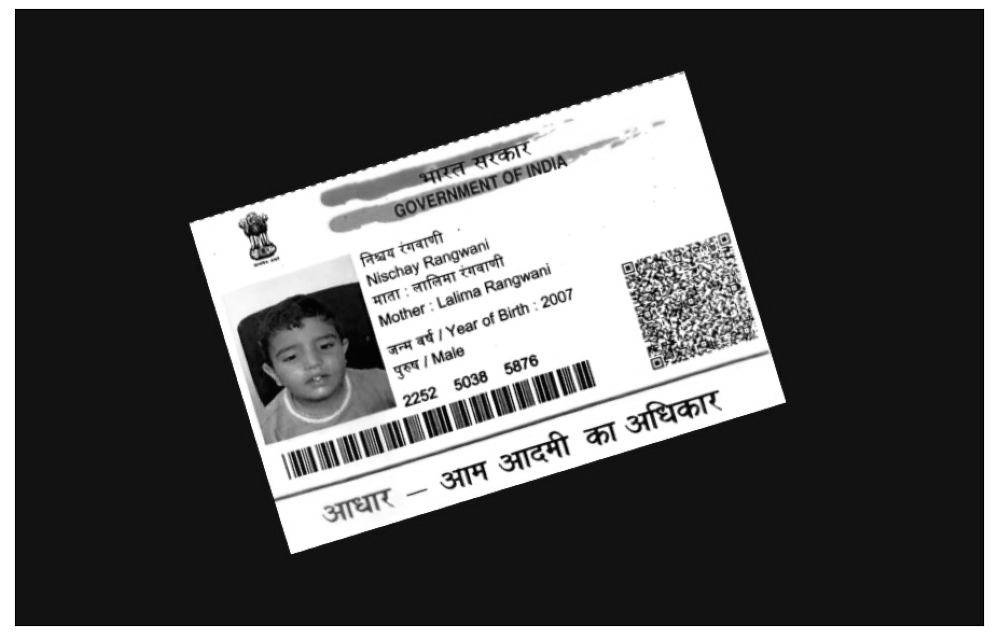

In [185]:
# Converting the image to grayscale

def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_img = get_grayscale(img)

plot_image(gray_img, cmap='gray')
plt.show()

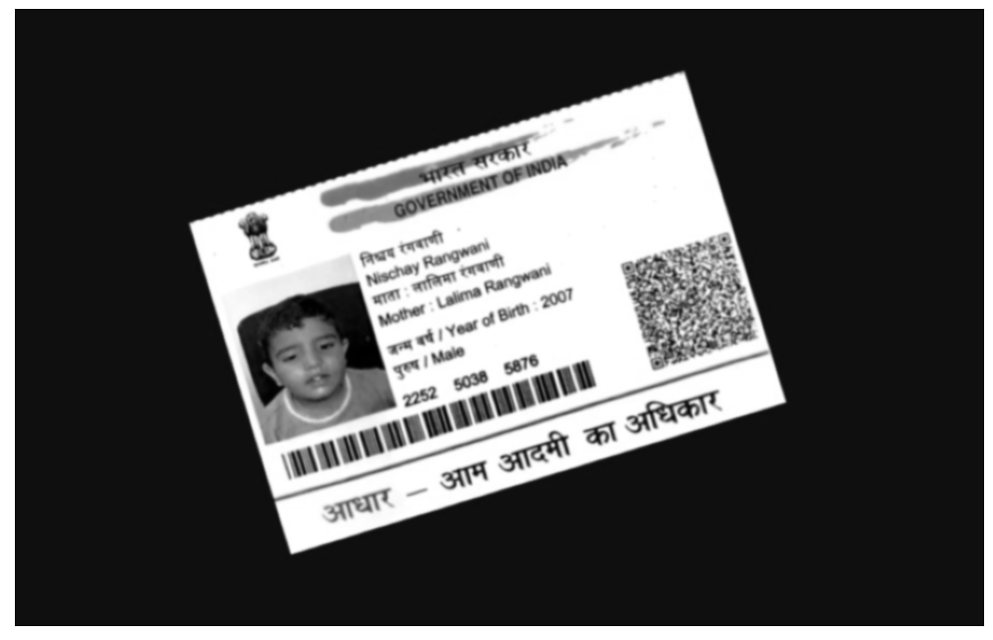

In [186]:
# Applying Gaussian Blur

def remove_noise(image):
    return cv2.GaussianBlur(gray_img,(5,5),1)

blur_img = remove_noise(gray_img)

plot_image(blur_img, cmap='gray')
plt.show()

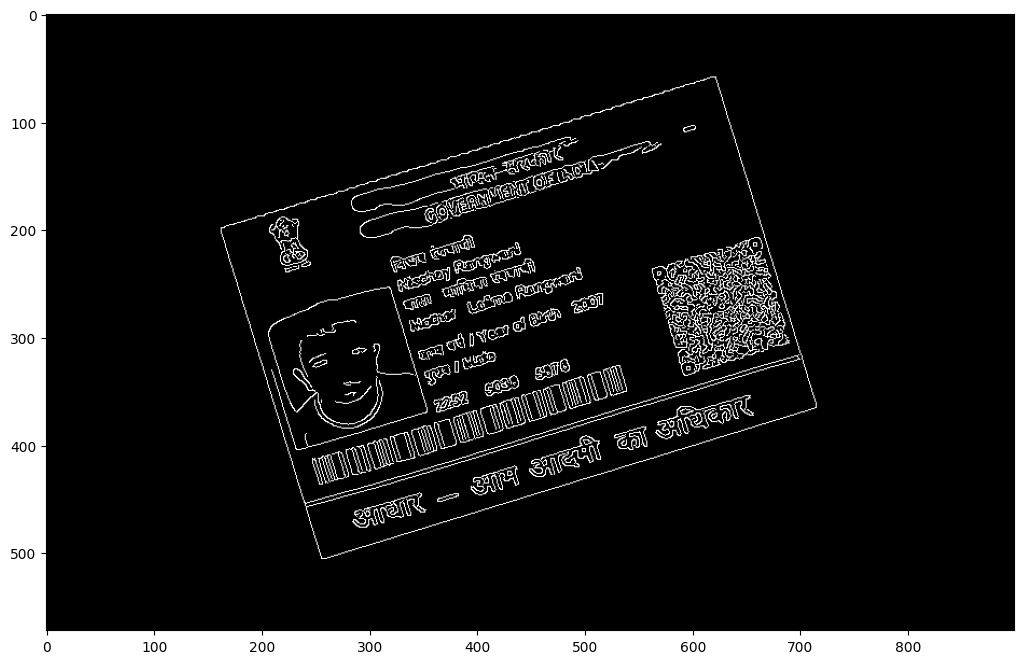

In [187]:
# Applying Canny Edge Detection

def Edge_detection(image):
    return cv2.Canny(blur_img,100,200)

edged_img = Edge_detection(blur_img)

plt.imshow(edged_img, cmap='gray')
plt.show()

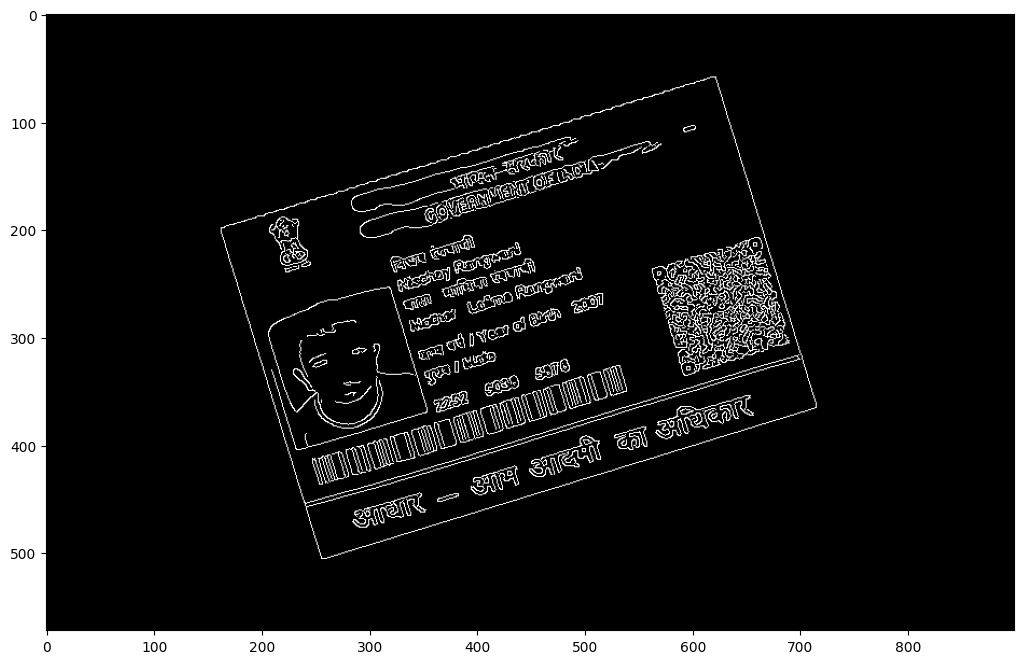

In [188]:
# Applying thresholding 

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

thresholded_img = thresholding(edged_img)

plt.imshow(thresholded_img, cmap='gray')
plt.show()

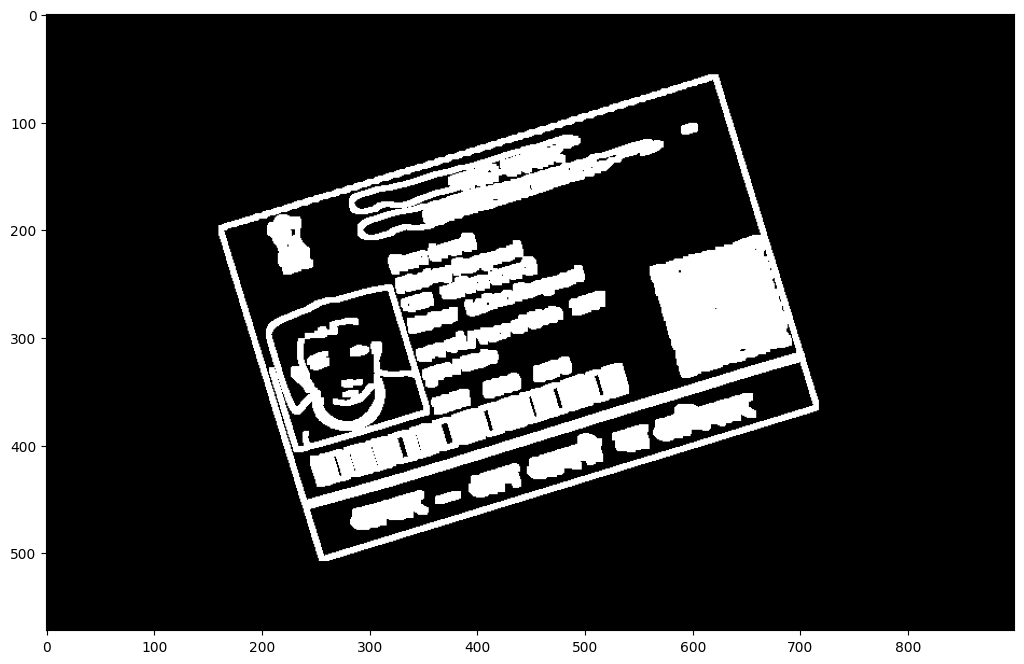

In [189]:
# Applying Dilation

def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 2)

dilated_image = dilate(thresholded_img)

plt.imshow(dilated_image, cmap='gray')
plt.show()

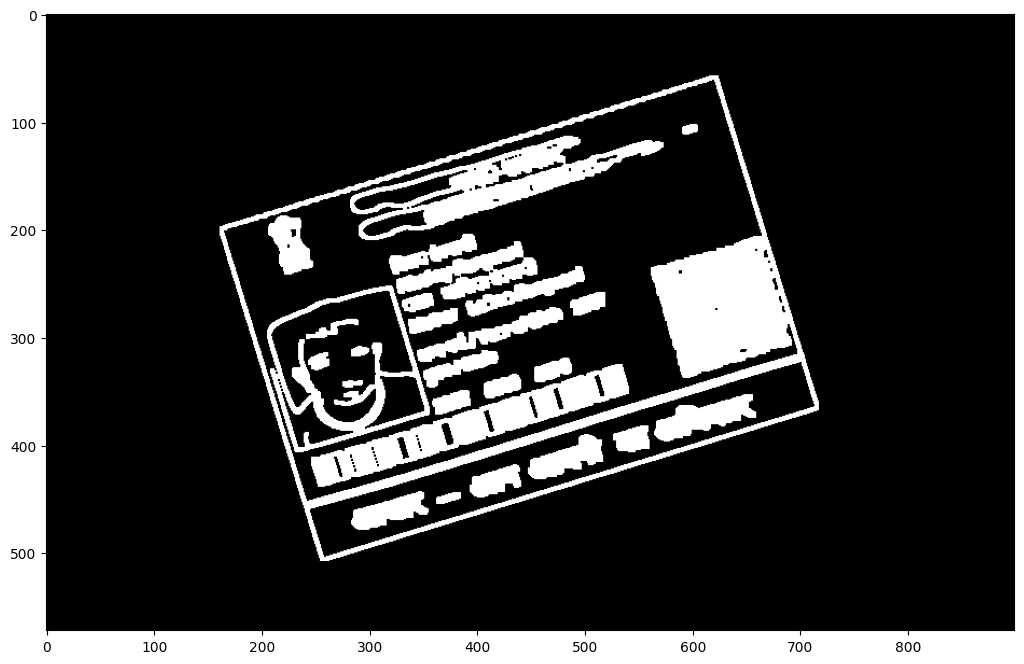

In [190]:
# Applying Erosion

def erode(image):
    kernel = np.ones((2,2),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

eroded_image = erode(dilated_image)

plt.imshow(eroded_image, cmap='gray')
plt.show()

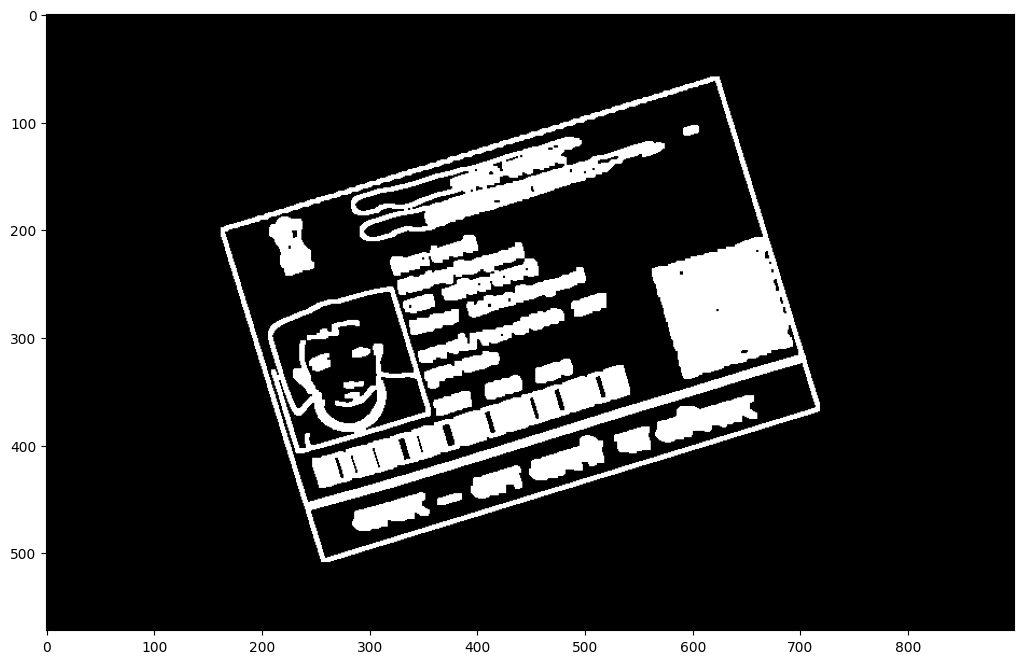

In [191]:
# opening - erosion followed by dilation

def opening(image):
    kernel = np.ones((2,2),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

opening_image = opening(eroded_image)

plt.imshow(opening_image, cmap='gray')
plt.show()

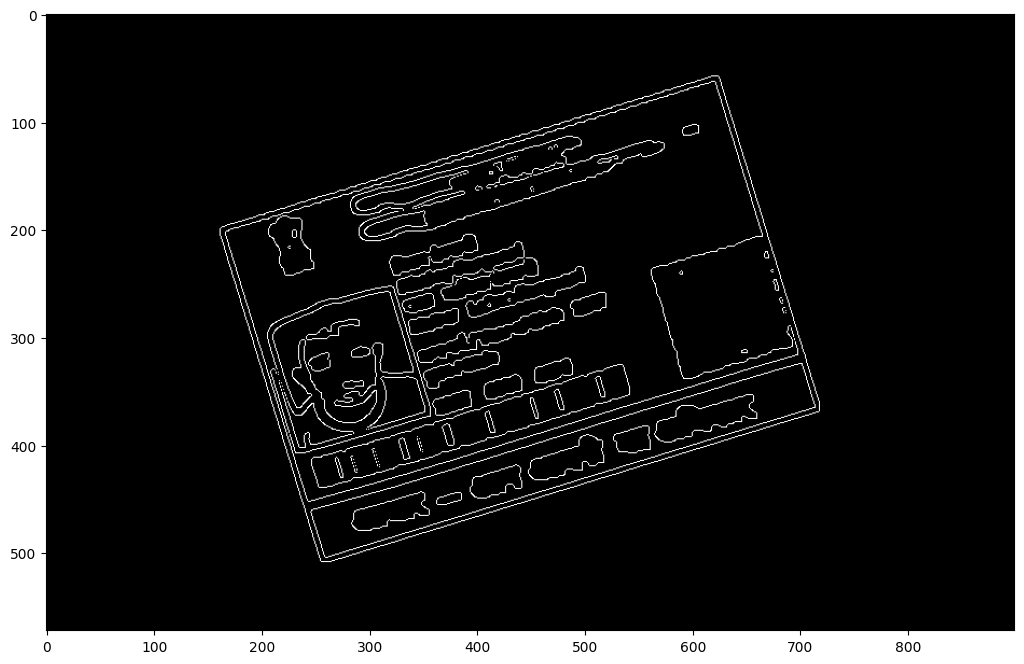

In [192]:
# Canny edge detection

def canny(image):
    return cv2.Canny(image, 75, 200)

edged_image = canny(opening_image)

plt.imshow(edged_image, cmap='gray')
plt.show()

In [193]:
# # Applying skew correction

# def deskew(image):
#     coords = np.column_stack(np.where(image > 0))
#     angle = cv2.minAreaRect(coords)[-1]
#     if angle < -45:
#         angle = -(90 + angle)
#     else:
#         angle = -angle
#     (h, w) = image.shape[:2]
#     center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#     return rotated

# deskewed_image = deskew(edged_image)

# plt.imshow(opening_image, cmap='gray')
# plt.show()

In [194]:
# # template matching
# def match_template(image, template):
#     return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

# matched_image = match_template(deskewed_image)

# plt.imshow(edged_image, cmap='gray')
# plt.show()

In [195]:
# Creating Wrapping Funcctions

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

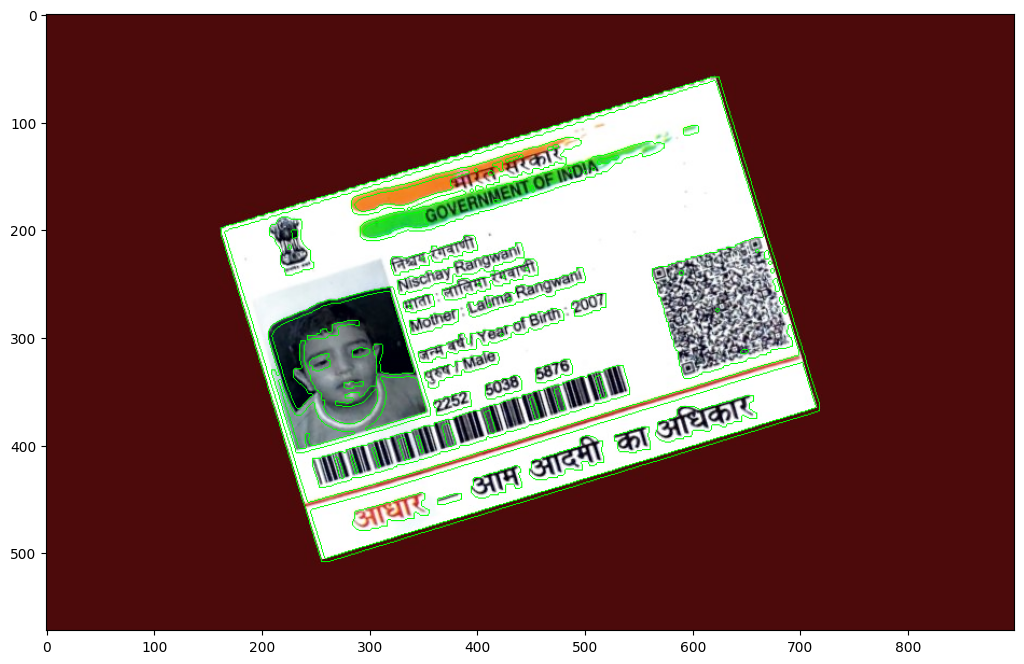

In [196]:
# Detecting Contours

contours, _ = cv2.findContours(opening_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

outline_contours = img.copy()
cv2.drawContours(outline_contours, contours, contourIdx=-1,color=(0, 255, 0))

plt.imshow(outline_contours, cmap='gray')
plt.show()

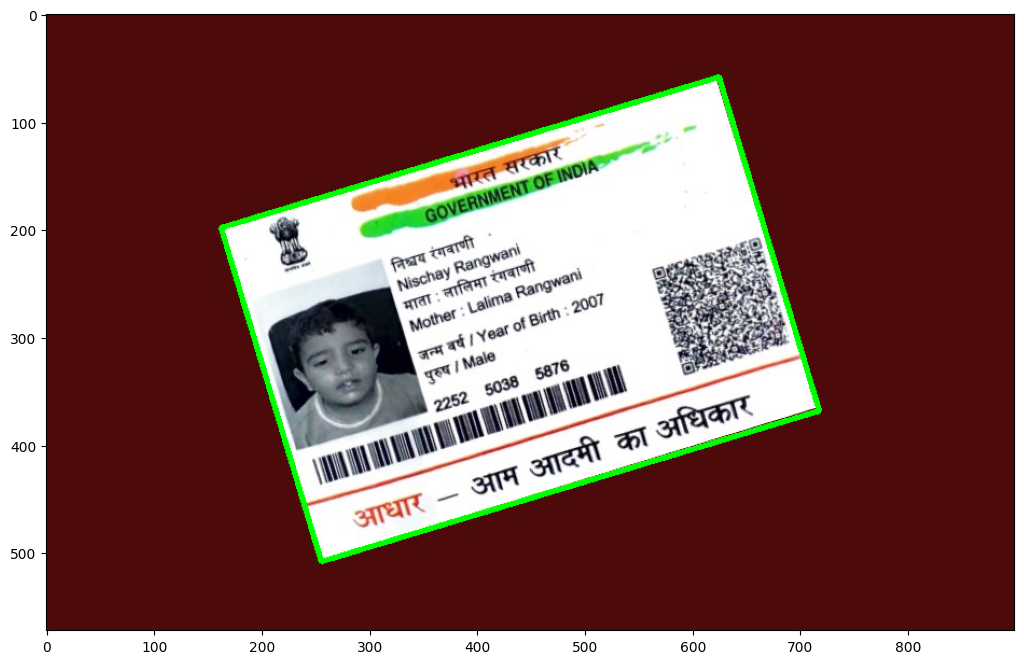

In [197]:
# Applying Ouline Contour

# go through each contour
for contour in contours:
    # we approximate the contour
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
    # if we found a countour with 4 points we break the for loop
    # (we can assume that we have found our document)
    if len(approx) == 4:
        doc_cnts = approx
        break
        
# We draw the contours on the original image not the modified one
all_contours = img.copy()
cv2.drawContours(all_contours, [doc_cnts], -1, (0, 255, 0), 3)

plt.imshow(all_contours)
plt.show()

---

# <center>  3. Text Extraction

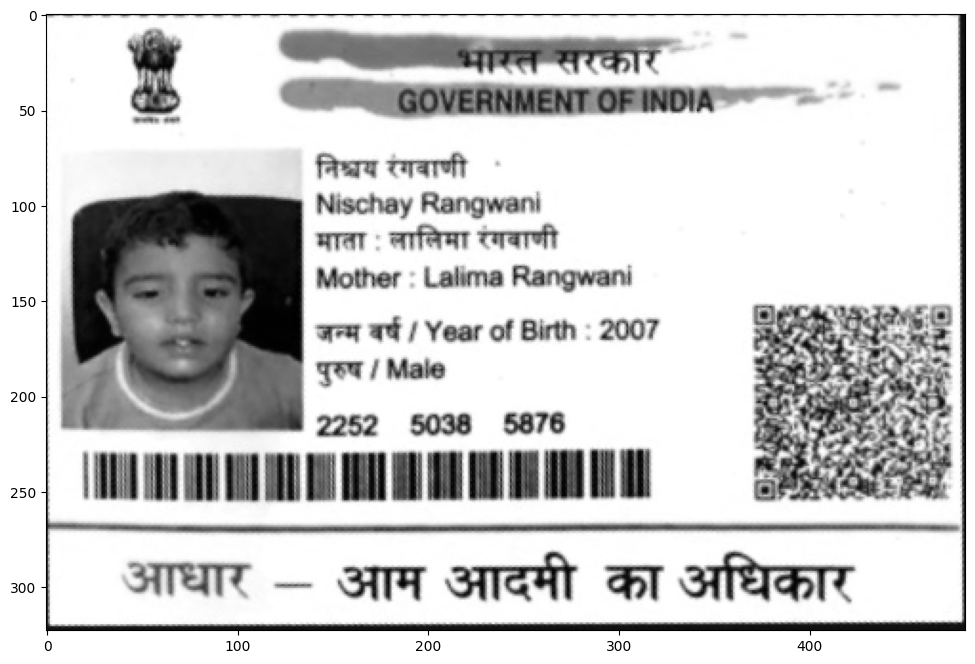

In [198]:
# Cropping Image

# cv2.imshow("Contours of the document", orig_image)
# apply warp perspective to get the top-down view
warped = four_point_transform(img, doc_cnts.reshape(4, 2))
# convert the warped image to grayscale
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# cv2.imshow("Scanned", cv2.resize(warped, (600, 800)))

plt.imshow(warped, cmap='gray')
plt.show()

In [199]:
# Extracting text from cropped image
out_below = pytesseract.image_to_string(warped)
print(out_below)

wea wt / Year of Birth : 2007
qet/ Male

2252 5038 5876




---

# <center> 4. Batch Processing

In [200]:
## Reading multiple files from images directory

file_list = glob.glob(
    r'../input/documents-scan/*.png'
)

pprint(file_list)

[]


In [201]:
# Plotting the images
plt.figure(figsize=[16,8])

def plot_multple_images(e, i):
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(3,5,e+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

for e, i in enumerate(file_list):
    plot_multple_images(e, i)
    
plt.show()

<Figure size 1600x800 with 0 Axes>

In [202]:
def recognize_text(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img,(5,5),0)

    edged_img = cv2.Canny(blur_img,75,200)

    contours, _ = cv2.findContours(edged_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    outline_contours = img.copy()
    cv2.drawContours(outline_contours, contours, contourIdx=-1,color=(0, 255, 0))

    # go through each contour
    for contour in contours:
        # we approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
        # if we found a countour with 4 points we break the for loop
        # (we can assume that we have found our document)
        if len(approx) == 4:
            doc_cnts = approx
            break

    warped = four_point_transform(img, doc_cnts.reshape(4, 2))
    # convert the warped image to grayscale
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)    

    pytesseract.pytesseract.tesseract_cmd = r'tesseract'

    out_below = pytesseract.image_to_string(warped)
    print(out_below)
    print('='*100,'\n\n')
    
[recognize_text(i) for i in file_list]

[]

---

In [203]:
#<<<--------------------------------------THE END---------------------------------------->>>